In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import integrate
from importlib import reload
import datetime as dt
sys.path.append(r'D:\07. Software\jupyter')
# sys.path.append(r'D:\My Drive go.ugr.es\07. Software\jupyter')
from utils_gfat import lidar, plot, aeronet, lidarQA, ecmwf
from utils_gfat import lidar_elastic_retrieval
import lidar_processing.lidar_processing.helper_functions as helper_functions
import pdb

In [3]:
#Define date
datestr = '20210709'
date_ = dt.datetime.strptime(datestr, '%Y%m%d')
year, month, day = date_.year, date_.month, date_.day
ymin_referece = 7000
ymax_referece = 8000
ymax = 9000
resolution_time = 30
profile_time = np.arange(date_,date_+dt.timedelta(days=1),dt.timedelta(minutes=resolution_time))

In [5]:
#Load data
#LIDAR
rs_fl = os.path.join(r'Y:\datos\MULHACEN\1a\%d\%02d\%02d' % (year, month, day), 'mhc_1a_Prs_%s.nc' % datestr)  
dc_fl = os.path.join(r'Y:\datos\MULHACEN\1a\%d\%02d\%02d' % (year, month, day), 'mhc_1a_Pdc_%s_*.nc' % datestr)  
ecmwf_fl = os.path.join(r'Y:\datos\ECMWF\%s' % year, '%s_granada_ecmwf.nc' % datestr)
outputdir = r'C:\Users\Usuario\Downloads'

#CIMEL
maindir = r'D:\00. PRODUCCIÓN CIENTÍFICA\00.1 articulos I\ACI_AERONET\lev15_all'
filepath_granada = os.path.join(maindir, '20040101_20211231_Granada.lev15')
filepath_poyo = os.path.join(maindir, '20110101_20211231_Cerro_Poyos.lev15')
filepath_albergue = os.path.join(maindir, '20160101_20181231_Albergue_UGR.all')

file = {'granada': filepath_granada, 'poyo': filepath_poyo,
        'albergue': filepath_albergue}
dfd = {}
for _key in ['granada', 'poyo']:
    df_ = aeronet.reader_all(file[_key])
    df_ = aeronet.lidar_wavelengths_lev15(df_)
    dfd[_key] = df_.copy()
    
#ECMWF
ecmwf_ds = ecmwf.reader(ecmwf_fl)

In [7]:
channel_dict={355: [4], 532: [0,2], 1064:[6]}
rcs_dict={355: 'corrected_rcs_04', 532: 'total_rcs532_an', 1064:'corrected_rcs_06'}
lr = {355: np.nan*np.ones(len(profile_time)), 532: np.nan*np.ones(len(profile_time)), 1064: np.nan*np.ones(len(profile_time))}
for idx, time_ in enumerate(profile_time):
    time_ini = time_.astype(dt.datetime)
    time_ini_str = dt.datetime.strftime(time_ini,'%Y%m%dT%H%M%S')
    time_end = time_ini + dt.timedelta(minutes=resolution_time)
    time_end_str = dt.datetime.strftime(time_end,'%Y%m%dT%H%M%S')
    
    for wavelength in [355, 532, 1064]:       
        channels_ = channel_dict[wavelength]
        rcs_name = rcs_dict[wavelength]
        #AERONET
        filter_conditions = np.logical_and(dfd['granada'].index>=time_ini, dfd['granada'].index<time_end)
        if filter_conditions.any():            
            aod_reference = dfd['granada']['AOD_%dnm' % wavelength][filter_conditions].mean()
            
            #Lidar signal
            wds = lidar.preprocessing(rs_fl, dc_fl, channels=channels_, 
                                      deadtime_flag=False, 
                                      zerobin_flag=True,
                                      ini_date=time_ini_str, 
                                      end_date=time_end_str,
                                      end_range=ymax)
            height = wds['range'].values

            #ECMWF
            pressure_prf, temperature_prf = ecmwf.level2height(ecmwf_ds.sel(time=slice(time_ini_str,time_end_str)).mean('time'), height)
            molecular_profiles = lidarQA.molecular_properties(wavelength, pressure_prf, temperature_prf, height, component='cabannes')            
            beta_mol = molecular_profiles['molecular_beta'].values
            lr_mol = molecular_profiles['molecular_lidar_ratio'].values
            
            
            rcs = wds[rcs_name].sel(time=slice(time_ini,time_end)).mean('time').values
            lr[wavelength][idx], rel_diff_aod, success = lidar_elastic_retrieval.find_lidar_ratio(rcs, height, beta_mol, lr_mol, 
                                                 aod_reference, **{'ymin':ymin_referece, 'ymax':ymax_referece}, 
                                                 debugging=False)
            print([wavelength, lr[wavelength][idx], rel_diff_aod, success])

LR355 = xr.DataArray(lr[355], dims=['time'], coords={'time': profile_time})
LR532 = xr.DataArray(lr[532], dims=['time'], coords={'time': profile_time})
LR1064 = xr.DataArray(lr[1064], dims=['time'], coords={'time': profile_time})
LR = xr.Dataset({'LR355': LR355, 'LR532': LR532, 'LR1064': LR1064})

LR.to_netcdf(os.path.join(outputdir,'lr_%s.nc' % datestr))

plt.scatter(profile_time,lr[355])
plt.scatter(profile_time,lr[532])
plt.scatter(profile_time,lr[1064])

['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T053000 to 20210709T060000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
INFO. Start Get Bin Zero
INFO. End Get Bin Zero
LR found: 62.000000
[355, 62.0, -0.8976542862458835, True]
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T053000 to 20210709T060000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
INFO. Start Get Bin Zero
INFO. End Get Bin Zero
INFO. Start Get Bin Zero
INFO. End Get Bin Zero


KeyboardInterrupt: 

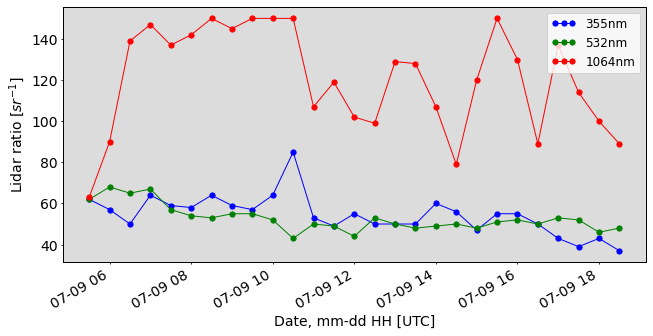

In [23]:
lr_fl = r'D:\07. Software\jupyter\SPIE - AERONET\lr_20210709.nc'
lr_ds = xr.open_dataset(lr_fl)
fig, ax = plt.subplots(figsize=[10,5])
lr_ds['LR355'].plot(c='b',marker='o',ax=ax, label='355nm')
lr_ds['LR532'].plot(c='g',marker='o',ax=ax, label='532nm')
lr_ds['LR1064'].plot(c='r',marker='o',ax=ax, label='1064nm')
ax.set_facecolor('gainsboro')
ax.set_xlabel('Date, mm-dd HH [UTC]')
ax.set_ylabel('Lidar ratio [$sr^{-1}$]')
ax.legend(fontsize=12)
plot.font_axes(ax,14)